
<center><h2></h2></center>
<center><h3>Proyecto 2</h3></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Sebastián Fuentes</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 16x16 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.

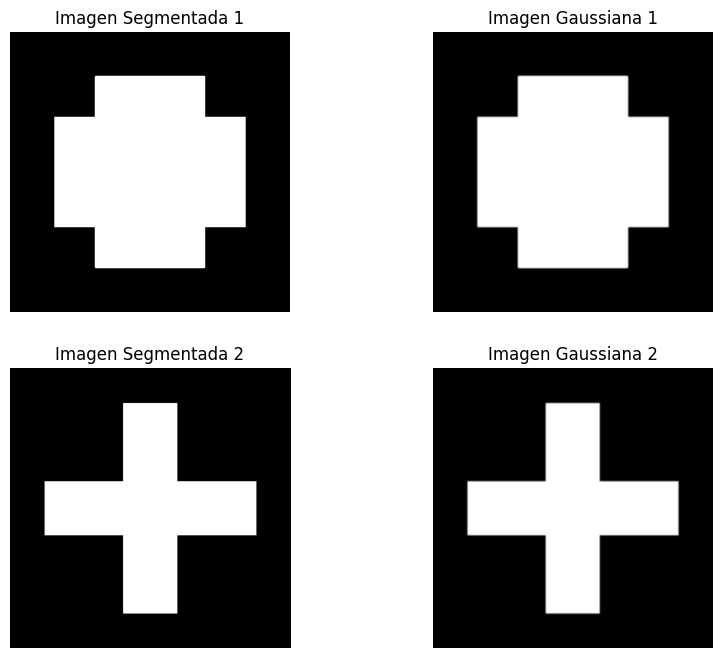

In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# Ruta donde están las imágenes
ruta_imagenes = "processed512"

# Crear una carpeta para las imágenes segmentadas y para las imágenes con filtro
os.makedirs("imagenes_segmentadas", exist_ok=True)
os.makedirs("imagenes_gaussianas", exist_ok=True)

# Listar todas las imágenes en la carpeta
nombres_imagenes = [f for f in os.listdir(ruta_imagenes) if f.endswith('.png')]

# Se cargan todas las imágenes en una lista de matrices
imagenes = [cv2.imread(os.path.join(ruta_imagenes, nombre_imagen), cv2.IMREAD_GRAYSCALE) for nombre_imagen in nombres_imagenes]

# Se binarizan las imágenes usando técnicas de vectorización
imagenes_segmentadas = [(cv2.threshold(imagen, 50, 255, cv2.THRESH_BINARY)[1] if imagen is not None else None) for imagen in imagenes]

# Aplicar un filtro gaussiano a las imágenes segmentadas y guardar las imágenes
imagenes_gaussianas = [(cv2.GaussianBlur(imagen_segmentada, (5, 5), 0) if imagen_segmentada is not None else None) for imagen_segmentada in imagenes_segmentadas]


# Guardar imágenes segmentadas y gaussianas, eliminar aquellas que no se pudieron cargar
for idx, (imagen_segmentada, imagen_gaussiana) in enumerate(zip(imagenes_segmentadas, imagenes_gaussianas)):
    if imagen_segmentada is not None:
        cv2.imwrite(os.path.join("imagenes_segmentadas", f"segmentada_{nombres_imagenes[idx]}"), imagen_segmentada)
    if imagen_gaussiana is not None:
        cv2.imwrite(os.path.join("imagenes_gaussianas", f"gaussiana_{nombres_imagenes[idx]}"), imagen_gaussiana)

# Mostrar un par de imágenes segmentadas y gaussianas
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title('Imagen Segmentada 1')
plt.imshow(imagenes_segmentadas[89], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Imagen Gaussiana 1')
plt.imshow(imagenes_gaussianas[89], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('Imagen Segmentada 2')
plt.imshow(imagenes_segmentadas[99], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('Imagen Gaussiana 2')
plt.imshow(imagenes_gaussianas[99], cmap='gray')
plt.axis('off')

plt.show()


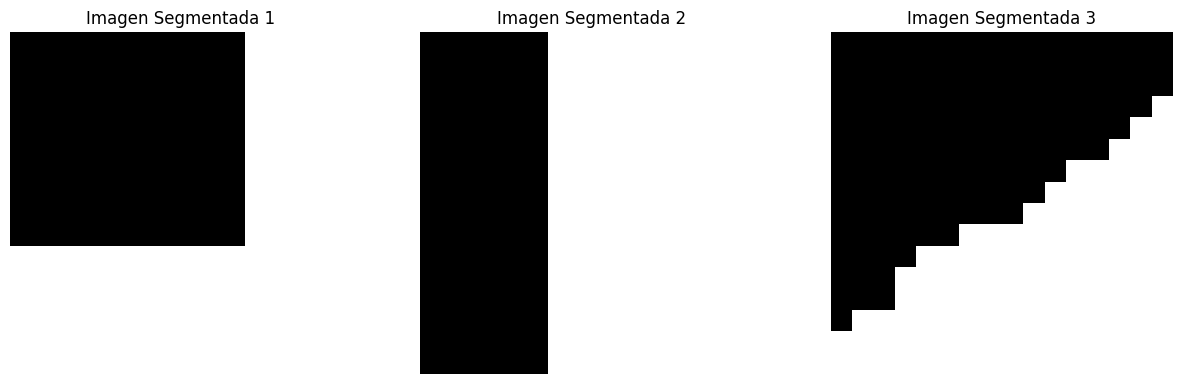

Tiempo de ejecución: 0.29 segundos


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

def segmentar_imagen(imagen, umbral=30):
    """
    Segmenta la imagen en escala de grises usando un umbral binario.
    """
    _, imagen_segmentada = cv2.threshold(imagen, umbral, 255, cv2.THRESH_BINARY)
    return imagen_segmentada

def guardar_imagen_segmentada(ruta_salida, nombre_imagen, imagen_segmentada):
    """
    Guarda la imagen segmentada en la ruta especificada.
    """
    cv2.imwrite(os.path.join(ruta_salida, nombre_imagen), imagen_segmentada)

def cargar_y_segmentar_imagenes(ruta_imagenes, ruta_salida):
    """
    Carga, segmenta y guarda todas las imágenes en la carpeta especificada.
    """
    nombres_imagenes = [f for f in os.listdir(ruta_imagenes) if f.endswith('.jpg')]
    imagenes_segmentadas = []

    for nombre_imagen in nombres_imagenes:
        ruta_completa = os.path.join(ruta_imagenes, nombre_imagen)
        imagen = cv2.imread(ruta_completa, cv2.IMREAD_GRAYSCALE)
        if imagen is not None:
            imagen_segmentada = segmentar_imagen(imagen)
            imagenes_segmentadas.append(imagen_segmentada)
            guardar_imagen_segmentada(ruta_salida, nombre_imagen, imagen_segmentada)

    return imagenes_segmentadas

def mostrar_imagenes_segmentadas(imagenes_segmentadas, num_imagenes_mostrar=3):
    """
    Muestra algunas de las imágenes segmentadas.
    """
    plt.figure(figsize=(15, 5))
    for i in range(min(num_imagenes_mostrar, len(imagenes_segmentadas))):
        plt.subplot(1, num_imagenes_mostrar, i+1)
        plt.title(f'Imagen Segmentada {i+1}')
        plt.imshow(imagenes_segmentadas[i], cmap='gray')
        plt.axis('off')
    plt.show()

# Iniciar el temporizador
start = timer()

# Rutas de las imágenes y de salida
ruta_imagenes2 = "/content"
ruta_salida = "imagenes_referencia_segmentadas"

# Crear carpeta de salida si no existe
os.makedirs(ruta_salida, exist_ok=True)

# Procesar imágenes
imagenes_segmentadas2 = cargar_y_segmentar_imagenes(ruta_imagenes2, ruta_salida)

# Mostrar imágenes segmentadas
mostrar_imagenes_segmentadas(imagenes_segmentadas2)

# Finalizar el temporizador
end = timer()
print("Tiempo de ejecución: {:.2f} segundos".format(end - start))



## 3. Operaciones de convolución
Para extraer las caracteristicas, debes realizar tantas operaciones de convolución como creas necesarias.
El resultado de tus convoluciones vas a usarlo para el proceso de matching.

## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# Se inicia el timer
start = timer()

# Función para realizar el template matching
def match_templates(imagen, templates):
    block_size = 32
    height, width = imagen.shape
    matches = {'box': 0, 'circ': 0, 'cross': 0}

    # Inicializar variables del mejor puntaje y la clase correspondiente
    best_score = -1
    best_class = None

    for y in range(0, height, block_size):
        for x in range(0, width, block_size):
            block = imagen[y:y+block_size, x:x+block_size]

            for name, template in templates.items():
                template_resized = cv2.resize(template, (block_size, block_size))
                result = cv2.matchTemplate(block, template_resized, cv2.TM_CCOEFF_NORMED)
                _, max_val, _, _ = cv2.minMaxLoc(result)

                # Actualizar el mejor puntaje y la clase si se encuentra una mejor coincidencia
                if max_val > best_score:
                    best_score = max_val
                    best_class = name

    matches[best_class] += 1

    return best_class

# Se cargan las plantillas de referencia segmentadas
templates = {
    'box': cv2.imread('imagenes_referencia_segmentadas/box_templae.jpg', cv2.IMREAD_GRAYSCALE),
    'circ': cv2.imread('imagenes_referencia_segmentadas/circ_templae.jpg', cv2.IMREAD_GRAYSCALE),
    'cross': cv2.imread('imagenes_referencia_segmentadas/cross_templae.jpg', cv2.IMREAD_GRAYSCALE)
}

# Ruta de las imágenes gaussianas
ruta_imagenes_gaussianas = "imagenes_gaussianas"

# Listar todas las imágenes gaussianas en la carpeta
nombres_imagenes_gaussianas = [f for f in os.listdir(ruta_imagenes_gaussianas) if f.endswith('.png')]

# Se cargan todas las imágenes gaussianas en una lista de matrices
imagenes_gaussianas = []
for nombre_imagen_gaussiana in nombres_imagenes_gaussianas:
    imagen_gaussiana = cv2.imread(os.path.join(ruta_imagenes_gaussianas, nombre_imagen_gaussiana), cv2.IMREAD_GRAYSCALE)
    if imagen_gaussiana is not None:
        imagenes_gaussianas.append(imagen_gaussiana)

# Realizar el matching para cada imagen y almacenar los resultados
predicciones = []
for idx, imagen_gaussiana in enumerate(imagenes_gaussianas):
    best_class = match_templates(imagen_gaussiana, templates)
    predicciones.append((nombres_imagenes_gaussianas[idx], best_class))

# Finalizar el timer
end = timer()
print("Tiempo de ejecucion: ", end - start)

# Imprimir predicciones
for nombre_imagen, prediccion in predicciones:
    print(f'Imagen: {nombre_imagen}, Clase predicha: {prediccion}')


Se truncaron las últimas líneas 5000 del resultado de transmisión.
Imagen: gaussiana_circ_01_freq_reflect_6d743d30-e161-11ee-907c-047c16a08772_0-930_80-90.png, Clase predicha: circ
Imagen: gaussiana_circ_01_freq_reflect_bc37ca3a-c608-11ee-97a2-047c16a08772_0-75_80-90.png, Clase predicha: circ
Imagen: gaussiana_cross_01_freq_reflect_8079ceb8-e14d-11ee-9a7b-047c16a08772_0-429_80-90.png, Clase predicha: box
Imagen: gaussiana_box_01_freq_reflect_0ed3a0e8-a653-11ee-9db6-047c16a08772_0-573_80-90.png, Clase predicha: box
Imagen: gaussiana_box_01_freq_reflect_0ed3a0e8-a653-11ee-9db6-047c16a08772_0-119_80-90.png, Clase predicha: circ
Imagen: gaussiana_cross_01_freq_reflect_e9503ad7-c681-11ee-809f-047c16a08772_0-542_80-90.png, Clase predicha: box
Imagen: gaussiana_circ_01_freq_reflect_56dee422-b317-11ee-bb58-047c16a08772_0-858_80-90.png, Clase predicha: box
Imagen: gaussiana_cross_01_freq_reflect_3be7fd33-bd16-11ee-be43-047c16a08772_0-1030_80-90.png, Clase predicha: box
Imagen: gaussiana_circ_01

# 5. Clasificación
De cada operación realizada obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.


Imagen: gaussiana_box_01_freq_reflect_2a1a6b92-ea35-11ee-b922-047c16a08772_0-726_80-90.png, Predicción: circ
Imagen: gaussiana_box_01_freq_reflect_e3744294-aba9-11ee-b4d0-047c16a08772_0-392_80-90.png, Predicción: cross
Imagen: gaussiana_cross_01_freq_reflect_b1de6052-eca2-11ee-9194-047c16a08772_0-750_80-90.png, Predicción: circ
Imagen: gaussiana_box_01_freq_reflect_0ed3a0e8-a653-11ee-9db6-047c16a08772_0-469_80-90.png, Predicción: cross
Imagen: gaussiana_box_01_freq_reflect_2a1a6b92-ea35-11ee-b922-047c16a08772_0-445_80-90.png, Predicción: box
Porcentaje de acierto para box: 44.17%
Porcentaje de acierto para circ: 61.75%
Porcentaje de acierto para cross: 28.82%
Error de clasificación general: 56.76% (0.57)
Porcentaje de acierto general: 43.24% (0.43)


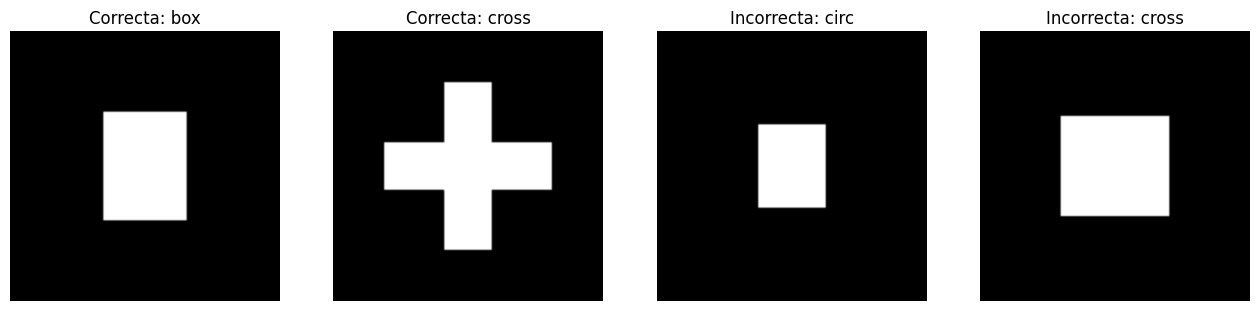

Tiempo de ejecucion:  0.7610726729999442


In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# Se inicia el timer
start = timer()

# Algunos ejemplos de predicciones
for i in range(min(5, len(predicciones))):
    print(f"Imagen: {predicciones[i][0]}, Predicción: {predicciones[i][1]}")

# Determinar las clases reales a partir de los nombres de los archivos
def obtener_clase_real(nombre_imagen):
    if "box" in nombre_imagen:
        return 'box'
    elif "cross" in nombre_imagen:
        return 'cross'
    elif "circ" in nombre_imagen:
        return 'circ'
    return None

# Calcular el porcentaje de acierto y el error de clasificación
aciertos = {'box': 0, 'circ': 0, 'cross': 0}
totales = {'box': 0, 'circ': 0, 'cross': 0}
errores = 0

for nombre_imagen, prediccion in predicciones:
    clase_real = obtener_clase_real(nombre_imagen)
    if clase_real:
        totales[clase_real] += 1
        if clase_real == prediccion:
            aciertos[clase_real] += 1
        else:
            errores += 1

porcentajes_acierto = {clase: (aciertos[clase] / totales[clase] * 100) if totales[clase] > 0 else 0 for clase in aciertos}
error_general = (errores / len(predicciones)) * 100
porcentaje_acierto_general = ((len(predicciones) - errores) / len(predicciones)) * 100
acierto_general_valor = (len(predicciones) - errores) / len(predicciones)

# Imprimir porcentaje de acierto, error general y porcentaje de aciertos general
for clase, porcentaje in porcentajes_acierto.items():
    print(f"Porcentaje de acierto para {clase}: {porcentaje:.2f}%")
print(f"Error de clasificación general: {error_general:.2f}% ({error_general / 100:.2f})")
print(f"Porcentaje de acierto general: {porcentaje_acierto_general:.2f}% ({acierto_general_valor:.2f})")

# Se muestran ejemplos de imágenes verdaderas y falsas
verdaderas = [prediccion for prediccion in predicciones if obtener_clase_real(prediccion[0]) == prediccion[1]]
falsas = [prediccion for prediccion in predicciones if obtener_clase_real(prediccion[0]) != prediccion[1]]

plt.figure(figsize=(16, 4))

# Mostrar ejemplos verdaderos
for i in range(min(2, len(verdaderas))):
    imagen_gaussiana = cv2.imread(os.path.join(ruta_imagenes_gaussianas, verdaderas[i][0]), cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 4, i+1)
    plt.title(f"Correcta: {verdaderas[i][1]}")
    plt.imshow(imagen_gaussiana, cmap='gray')
    plt.axis('off')

# Mostrar ejemplos falsos
for i in range(min(2, len(falsas))):
    imagen_gaussiana = cv2.imread(os.path.join(ruta_imagenes_gaussianas, falsas[i][0]), cv2.IMREAD_GRAYSCALE)
    plt.subplot(1, 4, i+3)
    plt.title(f"Incorrecta: {falsas[i][1]}")
    plt.imshow(imagen_gaussiana, cmap='gray')
    plt.axis('off')

plt.show()

# Finalizar el timer
end = timer()
print("Tiempo de ejecucion: ", end - start)
